In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [15]:
# Test function
def test(model, device, test_loader, epsilon):
    # Accuracy counter
    correct = 0
    total = 0
    # Adversarial example counter
    adv_examples = []
    label_translation = {0:0, 217:1, 482:2, 491:3, 497:4, 566:5, 569:6, 571:7, 574:8, 701:9}
    label_indices = torch.tensor(list(label_translation.keys())).to(device)
    # Loop over all examples in the test set
    for data, target in tqdm(test_loader):
        # Move the data and target to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)

        # Get the predicted class
        init_pred_filter = torch.index_select(output, 1, label_indices)
        init_pred = init_pred_filter.max(1, keepdim=True)[1]
        
        # If the initial prediction is wrong, don't bother attacking, just continue
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = nn.CrossEntropyLoss()(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred_filter = torch.index_select(output, 1, label_indices)
        final_pred = final_pred_filter.max(1, keepdim=True)[1]
        
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if epsilon == 0:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

        total += 1

    # Calculate final accuracy for this epsilon
    accuracy = correct/float(total)
    print("Epsilon: {}\tAccuracy = {} / {} = {}".format(epsilon, correct, total, accuracy))

    # Return the accuracy and an array of adversarial examples
    return accuracy, adv_examples

In [16]:
# Define the dataset and data loader for the test set
weights = ResNet50_Weights.IMAGENET1K_V1
preprocess = weights.transforms()

# Apply it to the input image
# img_transformed = preprocess(img)
test_set = datasets.ImageFolder('imagenette2-320/val', transform=preprocess)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)

# Load
model = models.resnet50(weights=weights)
model.eval()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Run test for each epsilon
accuracies = []
examples = []

epsilons = [0, .05, .1, .15, .2, .25, .3]
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)
    
# save the accuracies and examples
torch.save(accuracies, 'accuracies2.pt')
torch.save(examples, 'examples2.pt')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3925/3925 [03:47<00:00, 17.26it/s]


Epsilon: 0	Accuracy = 3221 / 3912 = 0.8233640081799591


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3925/3925 [03:41<00:00, 17.75it/s]


Epsilon: 0.05	Accuracy = 3255 / 3912 = 0.8320552147239264


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3925/3925 [03:29<00:00, 18.73it/s]


Epsilon: 0.1	Accuracy = 3126 / 3912 = 0.799079754601227


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3925/3925 [03:44<00:00, 17.49it/s]


Epsilon: 0.15	Accuracy = 2930 / 3912 = 0.7489775051124744


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3925/3925 [03:32<00:00, 18.51it/s]


Epsilon: 0.2	Accuracy = 2715 / 3912 = 0.6940184049079755


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3925/3925 [03:35<00:00, 18.23it/s]


Epsilon: 0.25	Accuracy = 2544 / 3912 = 0.6503067484662577


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3925/3925 [03:35<00:00, 18.18it/s]


Epsilon: 0.3	Accuracy = 2404 / 3912 = 0.614519427402863


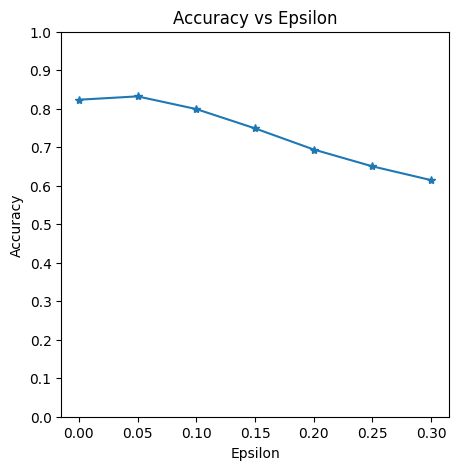

In [17]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()


6 0


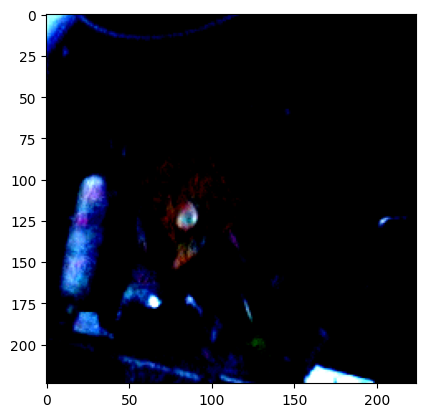

In [23]:
# plt
# for i in range(len(epsilons)):
#     for j in range(len(examples[i])):
#         orig,adv,ex = examples[i][j]
#         ex = ex.transpose(1,2,0)
#         plt.imshow(ex)
orig,adv,ex = examples[1][1]
ex = ex.transpose(1,2,0)
plt.imshow(ex)
print(orig, adv)

In [ ]:
l = {0:0, 217:1, 482:2, 491:3, 497:4, 566:5, 569:6, 571:7, 574:8, 701:9}
indx = list(l.keys())

In [ ]:
t = torch.load('output.pt')
# t.max(1, keepdim=True)


In [ ]:
# t.max(1, keepdim=True)
tt = torch.index_select(t, 1, torch.tensor(indx))
tt.max(1, keepdim=True)[1]